# Loading libraries

In [1]:
import glob2 as glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

import pandas as pd
pd.option_context("display.max_columns", None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading data

We took several amount of experiments in different locations and those are considered as datasets for training.

In [2]:
path= '/content/drive/MyDrive/Research/IBM Advanced Data Science/'

In [3]:
trainDF = pd.read_csv(path + 'sim_train_DF.csv')
trainDF.head()

,name,rssi,timestamp,experiment,user_at,timestamp2,beacon_at
0,kitchen1,-44.358269,1.0,1,kitchen,0.0,kitchen
1,kitchen1,-53.050031,2.0,1,kitchen,0.0,kitchen
2,kitchen1,-52.284467,3.0,1,kitchen,1.0,kitchen
3,kitchen1,-51.959420,4.0,1,kitchen,1.0,kitchen
4,kitchen1,-57.639364,5.0,1,kitchen,1.0,kitchen


Changing shape of dataframe

In [4]:
#testDF_pv = testDF.pivot_table(values='RSSI', columns = 'beacon_at', index=['Timestamp2', 'user_at', 'file_id'], aggfunc = max)
trainDF_pv = trainDF.pivot_table(values='rssi', columns = 'beacon_at', index=['timestamp2', 'user_at', 'experiment'], aggfunc = 'median')
trainDF_pv = trainDF_pv.reset_index()
trainDF_pv

beacon_at,timestamp2,user_at,experiment,kitchen,living,main,study
0,0.0,kitchen,1,-52.971474,-74.022937,-81.550564,-71.841174
1,0.0,kitchen,2,-53.388274,-72.124611,-80.402379,-68.372228
2,0.0,kitchen,3,-51.505815,-75.969089,-85.930964,-69.291606
3,0.0,living,1,-71.327449,-55.844318,-70.761797,-79.332652
4,0.0,living,2,-71.410709,-55.124476,-71.368118,-81.790393
...,...,...,...,...,...,...,...
967,80.0,main,2,-84.520011,-71.904011,-47.649971,-67.621495
968,80.0,main,3,-87.267193,-72.995120,-52.539834,-70.054536
969,80.0,study,1,-75.134410,-82.146982,-76.779070,-57.207924
970,80.0,study,2,-73.905856,-81.106149,-75.878604,-50.954770


## Feature creation

Change missing values based on median of each 'user_at'.

In [5]:
final=trainDF_pv.copy()

final["kitchen"] = final['kitchen'].fillna(final.groupby('user_at')['kitchen'].transform('median'))
final["living"] = final['living'].fillna(final.groupby('user_at')['living'].transform('median'))
final["main"] = final['main'].fillna(final.groupby('user_at')['main'].transform('median'))
final["study"] = final['study'].fillna(final.groupby('user_at')['study'].transform('median'))

final.sort_values(by=['user_at', 'experiment', 'timestamp2'], inplace=True)
final.reset_index(drop=True, inplace=True)
final = final.rename_axis(None, axis=1)
final['id'] = final.groupby(['user_at', 'experiment'])['experiment'].rank(method='first')
final.head()

,timestamp2,user_at,experiment,kitchen,living,main,study,id
0,0.0,kitchen,1,-52.971474,-74.022937,-81.550564,-71.841174,1.0
1,1.0,kitchen,1,-54.165559,-75.639799,-81.688024,-71.335710,2.0
2,2.0,kitchen,1,-49.694369,-73.242705,-86.618502,-73.667382,3.0
3,3.0,kitchen,1,-52.445194,-76.400419,-86.826654,-71.475889,4.0
4,4.0,kitchen,1,-53.795593,-73.585435,-81.914605,-70.408487,5.0


Creating a new dataframe with the fixed information from RSSIs and no missing values.

In [6]:
final_clean = final[['timestamp2', 'user_at', 'experiment', 'id']].copy()
final_clean[['kitchen', 'living', 'main', 'study']] = 0
final_clean.tail()

,timestamp2,user_at,experiment,id,kitchen,living,main,study
967,76.0,study,3,77.0,0,0,0,0
968,77.0,study,3,78.0,0,0,0,0
969,78.0,study,3,79.0,0,0,0,0
970,79.0,study,3,80.0,0,0,0,0
971,80.0,study,3,81.0,0,0,0,0


In [7]:
ba = trainDF['beacon_at'].unique().tolist()
fi = final['experiment'].unique().tolist()
ua = final['user_at'].unique().tolist()

for beacon in ba:
  for exp in fi:
    for userat in ua:
      tmp = final.loc[(final['experiment']==exp)&(final['user_at']==userat), ['id', beacon]]
      res = sm.nonparametric.lowess(tmp.iloc[:,1], tmp.iloc[:,0], frac = 1./3)
      res_loess = list(res[:,1])
      final_clean.loc[tmp.index, beacon] = res_loess

In [8]:
final.tail(10)

,timestamp2,user_at,experiment,kitchen,living,main,study,id
962,71.0,study,3,-75.181101,-82.688266,-78.562083,-56.244116,72.0
963,72.0,study,3,-77.865297,-83.375262,-75.610005,-54.776096,73.0
964,73.0,study,3,-76.464944,-83.819043,-76.769587,-56.278053,74.0
965,74.0,study,3,-76.448430,-86.116124,-74.595250,-57.610027,75.0
966,75.0,study,3,-75.047185,-82.135294,-80.071156,-51.641092,76.0
967,76.0,study,3,-76.445707,-84.533769,-74.986705,-53.608282,77.0
968,77.0,study,3,-79.910576,-81.787812,-76.577413,-54.728774,78.0
969,78.0,study,3,-77.767519,-82.427554,-76.582508,-54.124133,79.0
970,79.0,study,3,-76.558978,-80.134740,-77.813672,-54.584267,80.0
971,80.0,study,3,-78.798924,-82.935897,-78.143070,-53.579800,81.0


In [9]:
final_clean.tail(10)

,timestamp2,user_at,experiment,id,kitchen,living,main,study
962,71.0,study,3,72.0,-76.422324,-82.910528,-76.854398,-54.687997
963,72.0,study,3,73.0,-76.511662,-82.868935,-76.898470,-54.676703
964,73.0,study,3,74.0,-76.605929,-82.828951,-76.940908,-54.662593
965,74.0,study,3,75.0,-76.705413,-82.790274,-76.980940,-54.644977
966,75.0,study,3,76.0,-76.810258,-82.752268,-77.018432,-54.623022
967,76.0,study,3,77.0,-76.920687,-82.714159,-77.053712,-54.595802
968,77.0,study,3,78.0,-77.037206,-82.675298,-77.086998,-54.563081
969,78.0,study,3,79.0,-77.160233,-82.634902,-77.118865,-54.525043
970,79.0,study,3,80.0,-77.289570,-82.592462,-77.150100,-54.481933
971,80.0,study,3,81.0,-77.424781,-82.547769,-77.181530,-54.434080


Let's check how the denoise worked.

In [10]:
final_clean['experiment'].unique()

array([1, 2, 3])

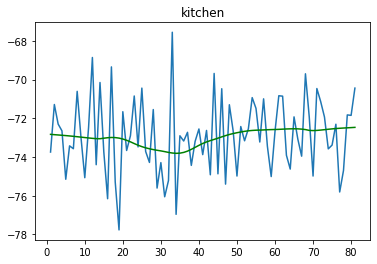

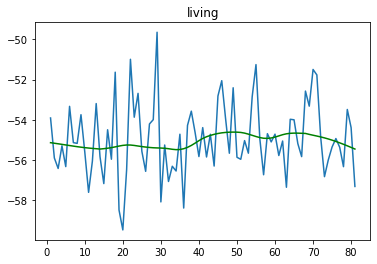

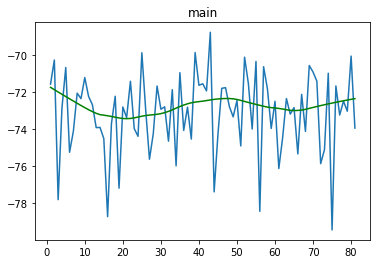

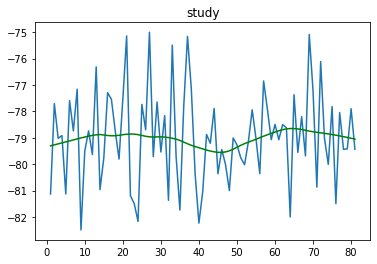

In [11]:
experiment = 3
userat = 'living'
tmpDf0 = final[(final['experiment']==experiment)&(final['user_at']==userat)]
tmpDf1 = final_clean[(final_clean['experiment']==experiment)&(final['user_at']==userat)]

plt.plot(tmpDf0['id'], tmpDf0['kitchen'])
plt.plot(tmpDf0['id'], tmpDf1['kitchen'], color='green')
plt.title('kitchen')
plt.show()

plt.plot(tmpDf0['id'], tmpDf0['living'])
plt.plot(tmpDf0['id'], tmpDf1['living'], color='green')
plt.title('living')
plt.show()

plt.plot(tmpDf0['id'], tmpDf0['main'])
plt.plot(tmpDf0['id'], tmpDf1['main'], color='green')
plt.title('main')
plt.show()

plt.plot(tmpDf0['id'], tmpDf0['study'])
plt.plot(tmpDf0['id'], tmpDf1['study'], color='green')
plt.title('study')
plt.show()



In [ ]:
final_clean.to_csv(path + 'sim_final_clean_train.csv', index=False)